<a href="https://colab.research.google.com/github/Smjfirna/Arsitektur-Compration/blob/main/MobileNet/50%2BAug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Dropout
import os
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.applications import MobileNet

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"smjayyy","key":"8eb172e224d83c7b56b4a2ef349b7c0d"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d smaranjitghose/corn-or-maize-leaf-disease-dataset

 88% 142M/161M [00:00<00:00, 191MB/s]
100% 161M/161M [00:01<00:00, 167MB/s]


In [5]:
!unzip -q corn-or-maize-leaf-disease-dataset.zip -d /content

In [6]:
dataset_dir = '/content/data'

In [7]:
print(os.listdir(dataset_dir))

['Common_Rust', 'Blight', 'Healthy', 'Gray_Leaf_Spot']


In [8]:
IMAGE_SIZE_mobilenet = 224

In [9]:
def make_data(label, DIR, img_list, label_list):
    for img in tqdm(os.listdir(DIR)):
        path = os.path.join(DIR, img)
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMAGE_SIZE_mobilenet, IMAGE_SIZE_mobilenet))
        img_list.append(np.array(img))
        label_list.append(str(label))

In [10]:
X = []
Z = []

In [11]:
for i, class_name in enumerate(['Common_Rust', 'Healthy', 'Gray_Leaf_Spot', 'Blight']):
    class_dir = os.path.join(dataset_dir, class_name)
    make_data(class_name, class_dir, X, Z)

100%|██████████| 1146/1146 [00:04<00:00, 237.73it/s]


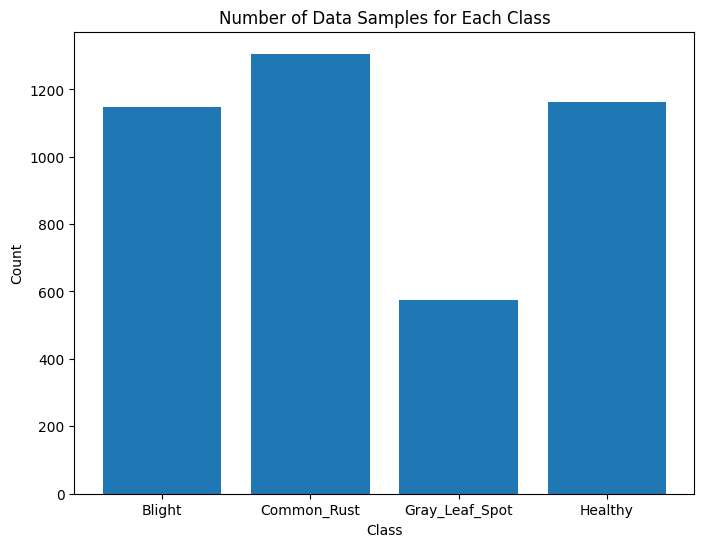

In [12]:
import matplotlib.pyplot as plt

# Menghitung jumlah data untuk setiap kelas
class_counts = {class_name: Z.count(class_name) for class_name in set(Z)}

# Menampilkan visualisasi jumlah data
plt.figure(figsize=(8, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of Data Samples for Each Class')
plt.show()

In [13]:
le = LabelEncoder()
Y = le.fit_transform(Z)
Y = to_categorical(Y, num_classes=len(le.classes_))

# Konversi ke array numpy
X = np.array(X)

# Memisahkan data menjadi data latih dan data uji
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Jumlah Data Train adalah :", len(X_train))
print("Jumlah Data Test adalah :", len(X_test))

Jumlah Data Train adalah : 3350
Jumlah Data Test adalah : 838


In [14]:
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

datagen.fit(X_train)

In [20]:
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE_mobilenet, IMAGE_SIZE_mobilenet, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

# Create the new model
model_mobilenet = Model(inputs=base_model.input, outputs=predictions)

model_mobilenet.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Menampilkan summary dari model
model_mobilenet.summary()

# Melatih model dengan data latih dan validasi
history_resnet50ver2 = model_mobilenet.fit(datagen.flow(X_train, Y_train), epochs=100, validation_data=(X_test, Y_test))

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128 

27/27 [==============================] - 1s 32ms/step


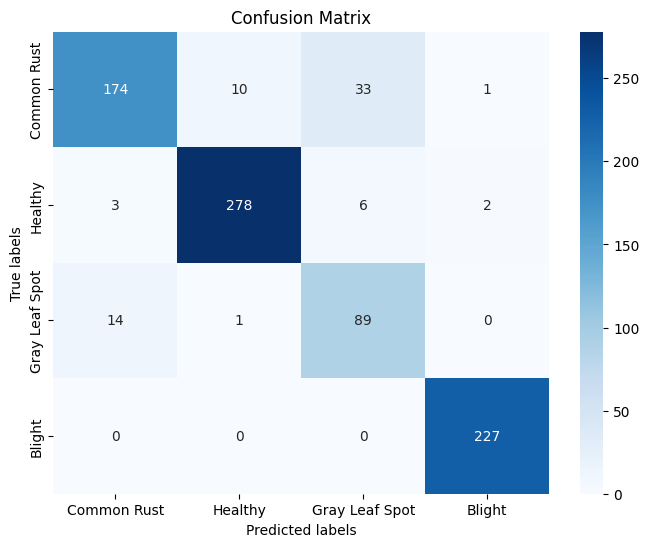


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.80      0.85       218
           1       0.96      0.96      0.96       289
           2       0.70      0.86      0.77       104
           3       0.99      1.00      0.99       227

    accuracy                           0.92       838
   macro avg       0.89      0.90      0.89       838
weighted avg       0.92      0.92      0.92       838



In [22]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Y_pred = model_mobilenet.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)

conf_matrix = confusion_matrix(Y_true, Y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Common Rust', 'Healthy', 'Gray Leaf Spot', 'Blight'], yticklabels=['Common Rust', 'Healthy', 'Gray Leaf Spot', 'Blight'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

class_report = classification_report(Y_true, Y_pred_classes)

print("\nClassification Report:")
print(class_report)